# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import (train_test_split, 
                                     ShuffleSplit, 
                                     cross_val_score, 
                                     GridSearchCV)
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, 
                             auc,
                             roc_curve, 
                             accuracy_score, 
                             f1_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay)

import xgboost
import lightgbm
import catboost

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

In [3]:
PATH_TO_DATA = "./"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [6]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [7]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

Подумайте об установке ujson, чтобы работать с JSON объектами быстрее


In [8]:
# Действовала по принципу "Накидать сначала много всего - потом, если надо, что-то убрать", поэтому может наблюдаться явление
# фича добавлена-фича удалена ¯\_(ツ)_/¯. Вообще основной понятый за несколько дней принцип - больше фич-разниц

def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # Посчитаем использование способностей командами
        radiant_ability_uses = 0
        dire_ability_uses = 0
        for i in range(10):
            player = match["players"][i]
            if i in [0, 1, 2, 3, 4]:
                radiant_ability_uses += sum(player["ability_uses"].values())
            else:
                dire_ability_uses += sum(player["ability_uses"].values())

        df_features.loc[match_id_hash, "radiant_ability_uses"] = radiant_ability_uses
        df_features.loc[match_id_hash, "dire_ability_uses"] = dire_ability_uses
        df_features.loc[match_id_hash, "diff_ability_uses"] = radiant_ability_uses - dire_ability_uses
        
        # Посчитаем pred_vict для команд
        radiant_pred_vict = 0
        dire_pred_vict = 0
        for i in range(10):
            player = match["players"][i]
            if i in [0, 1, 2, 3, 4]:
                radiant_pred_vict += player["pred_vict"]
            else:
                dire_pred_vict += player["pred_vict"]

        df_features.loc[match_id_hash, "radiant_pred_vict"] = radiant_pred_vict
        df_features.loc[match_id_hash, "dire_pred_vict"] = dire_pred_vict
        df_features.loc[match_id_hash, "diff_pred_vict"] = radiant_pred_vict - dire_pred_vict
        
        # Посчитаем количество убитых ближайших крипов командами
        radiant_nearby_creep_death_count = 0
        dire_nearby_creep_death_count = 0
        for i in range(10):
            player = match["players"][i]
            if i in [0, 1, 2, 3, 4]:
                radiant_nearby_creep_death_count += player["nearby_creep_death_count"]
            else:
                dire_nearby_creep_death_count += player["nearby_creep_death_count"]

        df_features.loc[match_id_hash, "radiant_nearby_creep_death_count"] = radiant_nearby_creep_death_count
        df_features.loc[match_id_hash, "dire_nearby_creep_death_count"] = dire_nearby_creep_death_count
        df_features.loc[match_id_hash, "diff_nearby_creep_death_count"] = radiant_nearby_creep_death_count - dire_nearby_creep_death_count
        
        # Посчитаем teamfight_participation
        radiant_teamfight_participation = 0
        dire_teamfight_participation = 0
        for i in range(10):
            player = match["players"][i]
            if i in [0, 1, 2, 3, 4]:
                radiant_teamfight_participation += player["teamfight_participation"]
            else:
                dire_teamfight_participation += player["teamfight_participation"]

        df_features.loc[match_id_hash, "radiant_teamfight_participation"] = radiant_teamfight_participation
        df_features.loc[match_id_hash, "dire_teamfight_participation"] = dire_teamfight_participation
        df_features.loc[match_id_hash, "diff_teamfight_participation"] = radiant_teamfight_participation - dire_teamfight_participation
        
        # Посчитаем количество multi kills для команд
        radiant_multi_kills = 0
        dire_multi_kills = 0
        for i in range(10):
            player = match["players"][i]
            if i in [0, 1, 2, 3, 4]:
                radiant_multi_kills += sum(player["multi_kills"].values())
            else:
                dire_multi_kills += sum(player["multi_kills"].values())

        df_features.loc[match_id_hash, "radiant_multi_kills"] = radiant_multi_kills
        df_features.loc[match_id_hash, "dire_multi_kills"] = dire_multi_kills
        df_features.loc[match_id_hash, "diff_multi_kills"] = radiant_multi_kills - dire_multi_kills
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [9]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

  0%|          | 0/31698 [00:00<?, ?it/s]

In [10]:
# Загрузим тестовые даные таблицу с признаками
X_test = df_test_features

# Добавим свои признаки в них
add_new_features(X_test, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [11]:
# Здесь я изучала различные показатели

with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 0 строку
    for i in range(1):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [30]:
print(match["players"][0]["runes"])

{}


In [13]:
for i in match["players"][0]:
    print(i)

player_slot
hero_id
hero_name
account_id_hash
ability_upgrades
obs_placed
sen_placed
creeps_stacked
camps_stacked
rune_pickups
firstblood_claimed
teamfight_participation
towers_killed
roshans_killed
observers_placed
stuns
max_hero_hit
times
gold_t
lh_t
dn_t
xp_t
obs_log
sen_log
obs_left_log
sen_left_log
purchase_log
kills_log
buyback_log
runes_log
obs
sen
actions
pings
purchase
gold_reasons
xp_reasons
killed
item_uses
ability_uses
hero_hits
damage
damage_taken
damage_inflictor
runes
killed_by
kill_streaks
multi_kills
life_state
healing
damage_inflictor_received
randomed
pred_vict
gold
lh
xp
x
y
hero_inventory
hero_stash
health
max_health
max_mana
level
kills
deaths
assists
denies
nearby_creep_death_count


In [14]:
# Посмотрим, что получилось

df_train_features_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,diff_teamfight_participation,radiant_multi_kills,dire_multi_kills,diff_multi_kills,radiant_actions,dire_actions,diff_actions,radiant_obs_placed,dire_obs_placed,diff_obs_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.375,3.0,0.0,3.0,18034.0,6849.0,11185.0,4.0,5.0,-1.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000,0.0,0.0,0.0,724.0,724.0,0.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000,0.0,0.0,0.0,3075.0,2424.0,651.0,1.0,0.0,1.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0.101,2.0,0.0,2.0,14330.0,12389.0,1941.0,6.0,7.0,-1.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0.167,1.0,1.0,0.0,12669.0,9825.0,2844.0,2.0,4.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,-0.097,4.0,6.0,-2.0,40794.0,54656.0,-13862.0,7.0,17.0,-10.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,0.559,4.0,0.0,4.0,34553.0,20733.0,13820.0,15.0,17.0,-2.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,-0.072,0.0,3.0,-3.0,13846.0,9929.0,3917.0,1.0,2.0,-1.0


In [15]:
# Новая функция для работы с имеющимися фичами

def add_new_features(df_features):
    """
    Аргументы
    -------
    df_features: таблица с данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    

    # Посчитаем KDA для команд
    df_features["radiant_kills"] = df_features[["r1_kills", "r2_kills", "r3_kills", "r4_kills", "r5_kills"]].sum(axis=1)
    df_features["dire_kills"] = df_features[["d1_kills", "d2_kills", "d3_kills", "d4_kills", "d5_kills"]].sum(axis=1)

    df_features["radiant_deaths"] = df_features[["r1_deaths", "r2_deaths", "r3_deaths", "r4_deaths", "r5_deaths"]].sum(axis=1)
    df_features["dire_deaths"] = df_features[["d1_deaths", "d2_deaths", "d3_deaths", "d4_deaths", "d5_deaths"]].sum(axis=1)

    df_features["radiant_assists"] = df_features[["r1_assists", "r2_assists", "r3_assists", "r4_assists", "r5_assists"]].sum(axis=1)
    df_features["dire_assists"] = df_features[["d1_assists", "d2_assists", "d3_assists", "d4_assists", "d5_assists"]].sum(axis=1)


    df_features["radiant_kda"] = df_features.apply(lambda row: 
                                                             (row.radiant_kills + row.radiant_assists) / row.radiant_deaths 
                                                   if row.radiant_deaths != 0 else row.radiant_kills + row.radiant_assists, 
                                                             axis = 1)
    df_features["dire_kda"] = df_features.apply(lambda row: 
                                                             (row.dire_kills + row.dire_assists) / row.dire_deaths 
                                                if row.dire_deaths != 0 else row.dire_kills + row.dire_assists, 
                                                             axis = 1)
    
    # Посчитаем золото для команд
    df_features["radiant_gold"] = df_features[["r1_gold", "r2_gold", "r3_gold", "r4_gold", "r5_gold"]].sum(axis=1)
    df_features["dire_gold"] = df_features[["d1_gold", "d2_gold", "d3_gold", "d4_gold", "d5_gold"]].sum(axis=1)
    df_features["gold_diff"] = df_features.apply(lambda row: row.radiant_gold - row.dire_gold, axis = 1)
    
    # Посчитаем опыт для команд
    df_features["radiant_xp"] = df_features[["r1_xp", "r2_xp", "r3_xp", "r4_xp", "r5_xp"]].sum(axis=1)
    df_features["dire_xp"] = df_features[["d1_xp", "d2_xp", "d3_xp", "d4_xp", "d5_xp"]].sum(axis=1)
    df_features["xp_diff"] = df_features.apply(lambda row: row.radiant_xp - row.dire_xp, axis = 1)
    
    # Посчитаем убитых рошанов
    df_features["radiant_roshans_killed"] = df_features[["r1_roshans_killed", 
                                                         "r2_roshans_killed", 
                                                         "r3_roshans_killed", 
                                                         "r4_roshans_killed", 
                                                         "r5_roshans_killed"]].sum(axis=1)
    df_features["dire_roshans_killed"] = df_features[["d1_roshans_killed", 
                                                      "d2_roshans_killed", 
                                                      "d3_roshans_killed", 
                                                      "d4_roshans_killed", 
                                                      "d5_roshans_killed"]].sum(axis=1)
    df_features["roshans_killed_diff"] = df_features.apply(lambda row: row.radiant_roshans_killed - row.dire_roshans_killed, axis = 1)
    
    # Посчитаем повреждение здоровья для каждого игрока в процентах
    df_features["r1_hurt"] = df_features.apply(lambda row: 100 - row.r1_health * 100 / row.r1_max_health, axis = 1)
    df_features["r2_hurt"] = df_features.apply(lambda row: 100 - row.r2_health * 100 / row.r2_max_health, axis = 1)
    df_features["r3_hurt"] = df_features.apply(lambda row: 100 - row.r3_health * 100 / row.r3_max_health, axis = 1)
    df_features["r4_hurt"] = df_features.apply(lambda row: 100 - row.r4_health * 100 / row.r4_max_health, axis = 1)
    df_features["r5_hurt"] = df_features.apply(lambda row: 100 - row.r5_health * 100 / row.r5_max_health, axis = 1)
    
    df_features["d1_hurt"] = df_features.apply(lambda row: 100 - row.d1_health * 100 / row.d1_max_health, axis = 1)
    df_features["d2_hurt"] = df_features.apply(lambda row: 100 - row.d2_health * 100 / row.d2_max_health, axis = 1)
    df_features["d3_hurt"] = df_features.apply(lambda row: 100 - row.d3_health * 100 / row.d3_max_health, axis = 1)
    df_features["d4_hurt"] = df_features.apply(lambda row: 100 - row.d4_health * 100 / row.d4_max_health, axis = 1)
    df_features["d5_hurt"] = df_features.apply(lambda row: 100 - row.d5_health * 100 / row.d5_max_health, axis = 1)
    
    df_features["radiant_hurt"] = df_features[["r1_hurt", "r2_hurt", "r3_hurt", "r4_hurt", "r5_hurt"]].sum(axis=1)
    df_features["dire_hurt"] = df_features[["d1_hurt", "d2_hurt", "d3_hurt", "d4_hurt", "d5_hurt"]].sum(axis=1)
    df_features["diff_hurt"] = df_features.apply(lambda row: row.radiant_hurt - row.dire_hurt, axis = 1)
    
    # Выведем первую кровь по командам в отдельные колонки
    df_features["radiant_firstblood"] = df_features.apply(lambda row: 1 if any([row.r1_firstblood_claimed, 
                                                                                 row.r2_firstblood_claimed,
                                                                                 row.r3_firstblood_claimed,
                                                                                 row.r4_firstblood_claimed,
                                                                                 row.r5_firstblood_claimed])
                                                          else 0, axis = 1)
    df_features["dire_firstblood"] = df_features.apply(lambda row: 1 if any([row.d1_firstblood_claimed, 
                                                                             row.d2_firstblood_claimed,
                                                                             row.d3_firstblood_claimed,
                                                                             row.d4_firstblood_claimed,
                                                                             row.d5_firstblood_claimed])
                                                       else 0, axis = 1)
    
    df_features["radiant_creeps_stacked"] = df_features[["r1_creeps_stacked", 
                                                         "r2_creeps_stacked", 
                                                         "r3_creeps_stacked", 
                                                         "r4_creeps_stacked", 
                                                         "r5_creeps_stacked"]].sum(axis=1)
    df_features["dire_creeps_stacked"] = df_features[["d1_creeps_stacked", 
                                                      "d2_creeps_stacked", 
                                                      "d3_creeps_stacked", 
                                                      "d4_creeps_stacked", 
                                                      "d5_creeps_stacked"]].sum(axis=1)
    df_features["diff_creeps_stacked"] = df_features.apply(lambda row: row.radiant_creeps_stacked - row.dire_creeps_stacked, axis = 1)
    
    df_features["radiant_rune_pickups"] = df_features[["r1_rune_pickups", 
                                                 "r2_rune_pickups", 
                                                 "r3_rune_pickups", 
                                                 "r4_rune_pickups", 
                                                 "r5_rune_pickups"]].sum(axis=1)
    df_features["dire_rune_pickups"] = df_features[["d1_rune_pickups", 
                                                      "d2_rune_pickups", 
                                                      "d3_rune_pickups", 
                                                      "d4_rune_pickups", 
                                                      "d5_rune_pickups"]].sum(axis=1)
    df_features["diff_rune_pickups"] = df_features.apply(lambda row: row.radiant_rune_pickups - row.dire_rune_pickups, axis = 1)
    
    df_features["radiant_x"] = df_features[["r1_x", 
                                             "r2_x", 
                                             "r3_x", 
                                             "r4_x", 
                                             "r5_x"]].sum(axis=1)
    df_features["dire_x"] = df_features[["d1_x", 
                                         "d2_x", 
                                         "d3_x", 
                                         "d4_x", 
                                         "d5_x"]].sum(axis=1)
    df_features["radiant_y"] = df_features[["r1_y", 
                                            "r2_y", 
                                            "r3_y", 
                                            "r4_y", 
                                            "r5_y"]].sum(axis=1)
    df_features["dire_y"] = df_features[["d1_y", 
                                         "d2_y",
                                         "d3_y", 
                                         "d4_y", 
                                         "d5_y"]].sum(axis=1)

In [16]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features_extended.copy()

# Добавим признаки в оба датасета
add_new_features(df_train_features_extended)

X_test = X_test.copy()
add_new_features(X_test)

In [17]:
# Посмотрим, что получилось

df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,radiant_creeps_stacked,dire_creeps_stacked,diff_creeps_stacked,radiant_rune_pickups,dire_rune_pickups,diff_rune_pickups,radiant_x,dire_x,radiant_y,dire_y
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,2,3,-1.0,13,14,-1.0,614,672,686,730
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.0,3,1,2.0,580,796,586,736
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.0,7,0,7.0,550,676,692,748
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,0,0.0,32,12,20.0,610,614,568,718
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,14,6,8.0,9,12,-3.0,604,716,526,588


In [18]:
# Обозначаем категориальные переменные для препроцессора

cat_cols = ["game_mode", 
            "radiant_firstblood", 
            "dire_firstblood"
           ]

In [19]:
# Ручной дроп того, что роняло скор, одна из самых запускаемых ячеек :)

df_train_features_extended = df_train_features_extended.drop(["radiant_kills", 
                                                              "radiant_deaths", 
                                                              "radiant_assists",
                                                              "dire_kills", 
                                                              "dire_deaths", 
                                                              "dire_assists",
                                                              "r1_hurt", 
                                                              "r2_hurt", 
                                                              "r3_hurt", 
                                                              "r4_hurt", 
                                                              "r5_hurt",
                                                              "d1_hurt", 
                                                              "d2_hurt", 
                                                              "d3_hurt", 
                                                              "d4_hurt", 
                                                              "d5_hurt",
                                                              "r1_firstblood_claimed", 
                                                              "r2_firstblood_claimed", 
                                                              "r3_firstblood_claimed", 
                                                              "r4_firstblood_claimed", 
                                                              "r5_firstblood_claimed",
                                                              "d1_firstblood_claimed", 
                                                              "d2_firstblood_claimed", 
                                                              "d3_firstblood_claimed", 
                                                              "d4_firstblood_claimed", 
                                                              "d5_firstblood_claimed",
                                                              "r1_creeps_stacked", 
                                                              "r2_creeps_stacked", 
                                                              "r3_creeps_stacked", 
                                                              "r4_creeps_stacked", 
                                                              "r5_creeps_stacked",
                                                              "d1_creeps_stacked", 
                                                              "d2_creeps_stacked", 
                                                              "d3_creeps_stacked", 
                                                              "d4_creeps_stacked", 
                                                              "d5_creeps_stacked",
                                                              "r1_camps_stacked", 
                                                              "r2_camps_stacked", 
                                                              "r3_camps_stacked", 
                                                              "r4_camps_stacked", 
                                                              "r5_camps_stacked",
                                                              "d1_camps_stacked", 
                                                              "d2_camps_stacked", 
                                                              "d3_camps_stacked", 
                                                              "d4_camps_stacked", 
                                                              "d5_camps_stacked",
                                                              "r1_rune_pickups", 
                                                              "r2_rune_pickups", 
                                                              "r3_rune_pickups", 
                                                              "r4_rune_pickups", 
                                                              "r5_rune_pickups",
                                                              "d1_rune_pickups", 
                                                              "d2_rune_pickups", 
                                                              "d3_rune_pickups", 
                                                              "d4_rune_pickups", 
                                                              "d5_rune_pickups",
                                                              "r1_x", 
                                                              "r2_x", 
                                                              "r3_x", 
                                                              "r4_x", 
                                                              "r5_x",
                                                              "d1_x", 
                                                              "d2_x", 
                                                              "d3_x", 
                                                              "d4_x", 
                                                              "d5_x",
                                                              "r1_y", 
                                                              "r2_y", 
                                                              "r3_y", 
                                                              "r4_y", 
                                                              "r5_y",
                                                              "d1_y", 
                                                              "d2_y", 
                                                              "d3_y", 
                                                              "d4_y", 
                                                              "d5_y",
                                                              "lobby_type",
                                                              "objectives_len",
                                                              "radiant_gold",
                                                              "dire_gold",
                                                              "radiant_xp",
                                                              "dire_xp",
                                                              "radiant_hurt",
                                                              "dire_hurt",
                                                              "radiant_creeps_stacked",
                                                              "dire_creeps_stacked", 
                                                              "radiant_rune_pickups",
                                                              "dire_rune_pickups",
                                                              "radiant_ability_uses",
                                                              "dire_ability_uses",
                                                              "radiant_pred_vict",
                                                              "dire_pred_vict",
                                                              "radiant_nearby_creep_death_count",
                                                              "dire_nearby_creep_death_count",
                                                              "radiant_teamfight_participation",
                                                              "dire_teamfight_participation",
                                                              "radiant_multi_kills",
                                                              "dire_multi_kills",
                                                              "radiant_hurt",
                                                              "dire_hurt",
                                                              "radiant_roshans_killed",
                                                              "dire_roshans_killed"
                                                              ], axis=1)

In [20]:
num_cols = list(df_train_features_extended.drop(cat_cols, axis=1))
all_features = cat_cols + num_cols
df_train_features_extended = df_train_features_extended[all_features]
df_train_features_extended

,game_mode,radiant_firstblood,dire_firstblood,game_time,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,gold_diff,xp_diff,roshans_killed_diff,diff_hurt,diff_creeps_stacked,diff_rune_pickups,radiant_x,dire_x,radiant_y,dire_y
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,4,0,1,658,10,15,7,2,0,7,...,5028.0,4641.0,0.0,-40.978612,-1.0,-1.0,614,672,686,730
6db558535151ea18ca70a6892197db41,23,0,0,21,0,101,0,0,0,0,...,400.0,0.0,0.0,-0.150538,0.0,2.0,580,796,586,736
19c39fe2af2b547e48708ca005c6ae74,22,0,0,160,0,57,0,0,0,1,...,1104.0,429.0,0.0,-136.060501,0.0,7.0,550,676,692,748
c96d629dc0c39f0c616d1949938a6ba6,22,1,0,1016,0,119,0,3,3,5,...,2831.0,-1225.0,0.0,12.153265,0.0,20.0,610,614,568,718
156c88bff4e9c4668b0f53df3d870f1b,22,0,1,582,2,12,3,1,2,9,...,-790.0,-554.0,0.0,22.873282,8.0,-3.0,604,716,526,588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,22,0,0,2666,8,99,9,11,9,3,...,-13706.0,-10136.0,-2.0,376.017535,-4.0,-21.0,592,386,544,496
308faee28efee2e66b39f9f2ba6ea9cf,22,0,1,2525,5,22,3,9,14,3,...,12231.0,18717.0,0.0,157.063254,-3.0,14.0,704,816,658,712
6066cc7417b43c749d551e123d00f0c8,4,0,1,1002,0,1,1,2,1,0,...,-4448.0,-4359.0,0.0,90.963766,0.0,-16.0,600,558,606,722


In [21]:
X = df_train_features_extended
y = df_train_targets["radiant_win"].values.astype("int8")

In [22]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

In [23]:
preprocessor.transformers

[('scaler',
  StandardScaler(),
  ['game_time',
   'chat_len',
   'r1_hero_id',
   'r1_kills',
   'r1_deaths',
   'r1_assists',
   'r1_denies',
   'r1_gold',
   'r1_lh',
   'r1_xp',
   'r1_health',
   'r1_max_health',
   'r1_max_mana',
   'r1_level',
   'r1_stuns',
   'r1_teamfight_participation',
   'r1_towers_killed',
   'r1_roshans_killed',
   'r1_obs_placed',
   'r1_sen_placed',
   'r2_hero_id',
   'r2_kills',
   'r2_deaths',
   'r2_assists',
   'r2_denies',
   'r2_gold',
   'r2_lh',
   'r2_xp',
   'r2_health',
   'r2_max_health',
   'r2_max_mana',
   'r2_level',
   'r2_stuns',
   'r2_teamfight_participation',
   'r2_towers_killed',
   'r2_roshans_killed',
   'r2_obs_placed',
   'r2_sen_placed',
   'r3_hero_id',
   'r3_kills',
   'r3_deaths',
   'r3_assists',
   'r3_denies',
   'r3_gold',
   'r3_lh',
   'r3_xp',
   'r3_health',
   'r3_max_health',
   'r3_max_mana',
   'r3_level',
   'r3_stuns',
   'r3_teamfight_participation',
   'r3_towers_killed',
   'r3_roshans_killed',
   'r3_o

In [24]:
X = df_train_features_extended[all_features]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=SEED)

In [25]:
cat = catboost.CatBoostClassifier(verbose=0, 
                                  depth=6, 
                                  learning_rate=0.05,
                                  random_seed=SEED)

For CatBoostClassifier roc_auc = 0.81631, accuracy = 0.72713
CPU times: user 11min 15s, sys: 59.4 s, total: 12min 15s
Wall time: 1min 43s


Text(0.5, 1.0, 'CatBoostClassifier confusion matrix')

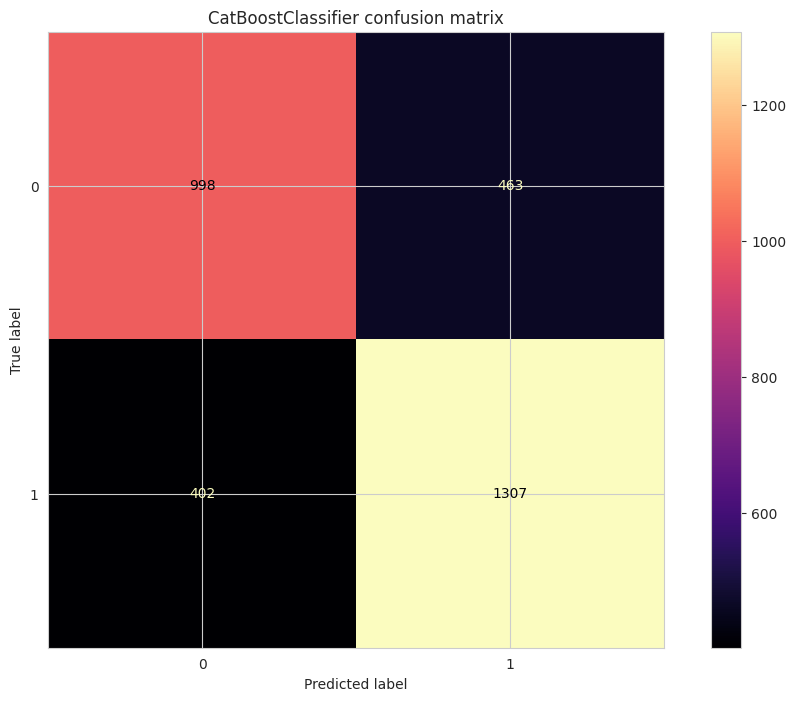

In [26]:
%%time
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("CAT", cat)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
cv_scores = cross_val_score(cat, X_train, y_train, cv=cv, scoring="roc_auc")

print(f"For CatBoostClassifier roc_auc = {round(cv_scores.mean(), 5)}, accuracy = {round(accuracy_score(y_valid, y_pred), 5)}")
ConfusionMatrixDisplay(confusion_matrix(y_valid, y_pred)).plot(cmap="magma")
plt.title("CatBoostClassifier confusion matrix");

CatBoostClassifier ROC AUC=0.81626


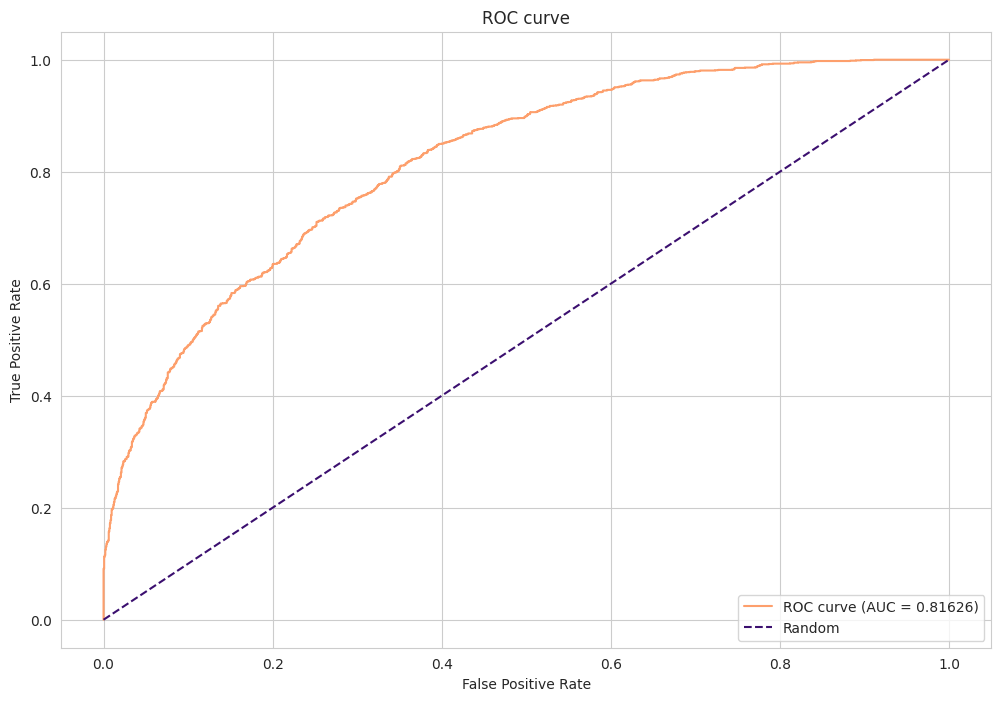

In [27]:
y_pred = pipeline.predict(X_valid)

lr_probs = pipeline.predict_proba(X_valid)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_valid, lr_probs)
print(f"CatBoostClassifier ROC AUC={round(lr_auc, 5)}")

# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_valid, lr_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="#FD9F6C",
         label=f"ROC curve (AUC = {round(roc_auc, 5)})")
plt.plot([0, 1], [0, 1], color="#3B0F6F", linestyle="--", label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### Посылка

In [31]:
y_test_pred = pipeline.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [32]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен как: {}".format(submission_filename))

Файл посылки сохранен как: submission_2023-04-09_23-04-45.csv
